In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchsummary import summary
import time
import numpy as np
import cupy as cp
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import load_digits


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

In [100]:
data = load_digits()

X = data['data']
y = data['target']

In [101]:
# we choose these numbers as more challenging (at the first glance in out opinion) to classify
 
X = X[np.logical_or(y == 7, y == 1)]
y = y[np.logical_or(y == 7, y == 1)]
y[y == 7] = 0 

In [102]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2)

In [103]:
train_X = Variable(torch.Tensor(train_X).float()).to(device)
test_X = Variable(torch.Tensor(test_X).float()).to(device)
train_y = Variable(torch.Tensor(train_y).float()).to(device)
test_y = Variable(torch.Tensor(test_y).float()).to(device)

In [104]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(64, 1, bias=True)

    def forward(self, x):
        return self.fc1(x)

In [137]:
def get_test_score(clf):
    clf.eval()
    predict_y = (F.sigmoid(clf(test_X)) > .5)[:,0]
    clf.train()
    return 100*accuracy_score(test_y.data, predict_y.data)

In [138]:
net = Net().to(device)

#if torch.cuda.device_count() > 1:
#        net = nn.DataParallel(net)
        
criterion = nn.BCEWithLogitsLoss().to(device)# cross entropy loss
opt = torch.optim.SGD(net.parameters(), weight_decay=.0001, lr=0.01)


for epoch in range(5):
    net.train()

    opt.zero_grad()
    out = net(train_X)
    loss = criterion(out, train_y.reshape(-1,1))
    loss.backward()
    opt.step()
    
    if epoch % 1 == 0:
        print( 'number of epoch', epoch, 'loss', loss.item())
        
get_test_score(net)

number of epoch 0 loss 1.3734697103500366
number of epoch 1 loss 3.2258026599884033
number of epoch 2 loss 1.4210211038589478
number of epoch 3 loss 1.8275127410888672
number of epoch 4 loss 0.4948650598526001


90.41095890410958

In [139]:
def eval_hessian(loss_grad, model):
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    l = g_vector.size(0)
    g_vector = g_vector.to(device)
    hessian = torch.zeros(l, l)
    for idx in range(l):
        grad2rd = torch.autograd.grad(g_vector[idx], model.parameters(), create_graph=True)
        cnt = 0
        for g in grad2rd:
            g2 = g.contiguous().view(-1) if cnt == 0 else torch.cat([g2, g.contiguous().view(-1)])
            cnt = 1
        hessian[idx] = g2
    return hessian

In [140]:
opt.zero_grad()
loss = criterion(net(train_X), train_y.reshape(-1,1))
grads = torch.autograd.grad(loss, opt.param_groups[0]['params'], create_graph=True)
hess = eval_hessian(grads, net)

In [146]:
net.eval()
sub_sizes = [5, 10, 20, 30, 40, 50]
for_plot = []
for sub_size in sub_sizes:
    ss = []
    acc_list = []
    print(sub_size)
    for i in range(train_X.size()[0]//sub_size):
        start = time.time()
        bdata = train_X[sub_size*i:sub_size*(i+1)]
        blabel = train_y[sub_size*i:sub_size*(i+1)]
        opt.zero_grad()
        loss = criterion(net(bdata), blabel.reshape(-1,1))
        grads = torch.autograd.grad(loss, opt.param_groups[0]['params'], create_graph=True)
        hess = eval_hessian(grads, net)
        sld = cp.linalg.slogdet(cp.asarray(hess.detach())+0.0001*cp.eye(65))
        ss.append(sld[1].item())
        del hess, grads, loss
        torch.cuda.empty_cache()


        clf_new = Net().to(device)
        opt_new = optim.SGD(clf_new.parameters(), weight_decay=0.01, lr=0.01, momentum=0.5)
        for _ in range(5):
            opt_new.zero_grad()
            preds = clf_new(bdata)
            loss = criterion(preds, blabel.reshape(-1,1))
            loss.backward()
            opt_new.step()

        accuracy = get_test_score(clf_new)
        acc_list.append(accuracy)

        del clf_new, opt_new
        torch.cuda.empty_cache()
        print('batch {:>3}, ss = {:>10.4f}, test acc = {:>2}, time = {:>7.4f}'.format(i, sld[1].item(), accuracy, time.time()-start))  
    for_plot.append((acc_list, ss))

5
batch   0, ss =  -548.4362, test acc = 71.23287671232876, time =  0.0387
batch   1, ss =  -550.8497, test acc = 57.534246575342465, time =  0.0352
batch   2, ss =  -548.0763, test acc = 67.12328767123287, time =  0.0351
batch   3, ss =  -554.6659, test acc = 80.82191780821918, time =  0.0350
batch   4, ss =  -569.2331, test acc = 49.31506849315068, time =  0.0355


/trinity/shared/opt/python-3.7.1/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


batch   5, ss =  -543.5514, test acc = 54.794520547945204, time =  0.0351
batch   6, ss =  -562.2175, test acc = 57.534246575342465, time =  0.0354
batch   7, ss =  -551.6399, test acc = 95.8904109589041, time =  0.0348
batch   8, ss =  -554.6814, test acc = 61.64383561643836, time =  0.0349
batch   9, ss =  -551.2842, test acc = 90.41095890410958, time =  0.0348
batch  10, ss =  -556.0420, test acc = 80.82191780821918, time =  0.0351
batch  11, ss =  -548.0588, test acc = 87.67123287671232, time =  0.0350
batch  12, ss =  -551.6344, test acc = 95.8904109589041, time =  0.0346
batch  13, ss =  -542.3822, test acc = 90.41095890410958, time =  0.0346
batch  14, ss =  -560.2710, test acc = 97.26027397260275, time =  0.0346
batch  15, ss =  -553.6507, test acc = 69.86301369863014, time =  0.0345
batch  16, ss =  -570.9230, test acc = 67.12328767123287, time =  0.0345
batch  17, ss =  -555.2165, test acc = 91.78082191780823, time =  0.0343
batch  18, ss =  -553.4649, test acc = 90.410958904

In [150]:
for i, sub_size in enumerate(sub_sizes):
    print(i//3, i%3)

0 0
0 1
0 2
1 0
1 1
1 2


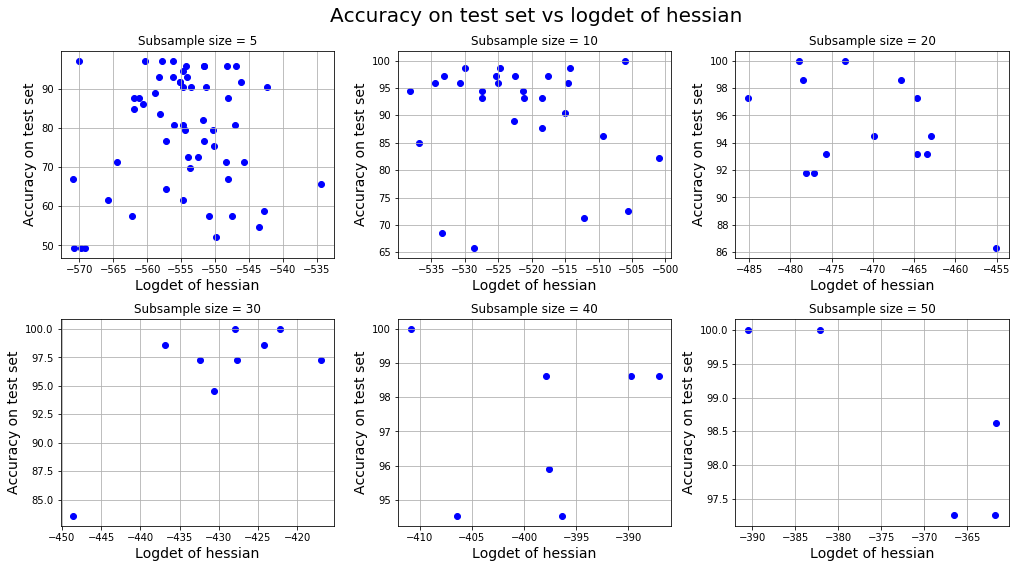

In [162]:
fig, ax = plt.subplots(2, 3, figsize=(15,8))
plt.suptitle('Accuracy on test set vs logdet of hessian', fontsize=20)
for i, sub_size in enumerate(sub_sizes):
    ax[i//3, i%3].scatter(for_plot[i][1], for_plot[i][0], c='b')
    ax[i//3, i%3].set_title('Subsample size = {}'.format(sub_size))
    ax[i//3, i%3].tick_params(axis='both', which='major', labelsize=10)
    ax[i//3, i%3].set_xlabel('Logdet of hessian', fontsize=14)
    ax[i//3, i%3].set_ylabel('Accuracy on test set', fontsize=14)
    ax[i//3, i%3].grid()
fig.tight_layout(rect=[0,0,.95,.95])

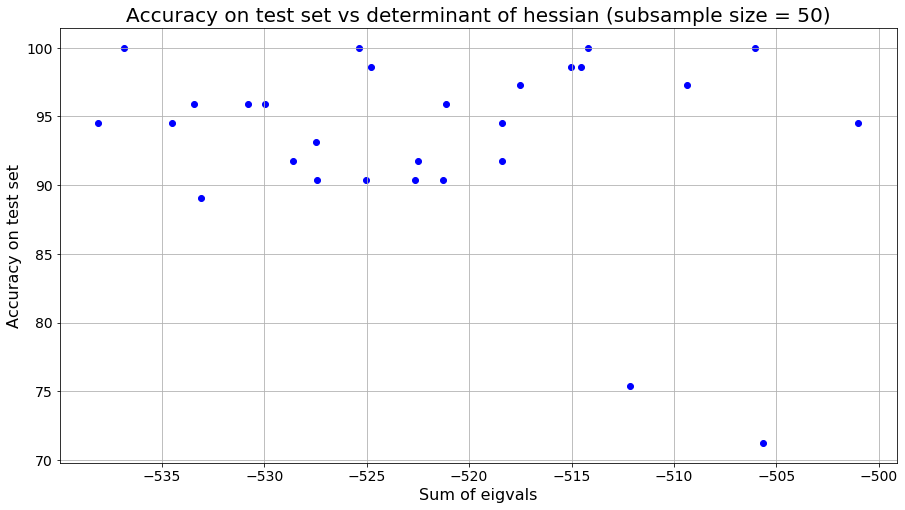

In [142]:
plt.title('Accuracy on test set vs logdet of hessian (subsample size = 50)', fontsize=20)
plt.scatter(ss, acc_list, c='b')
#plt.scatter(ss_old, acc_old, c='r')
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Sum of eigvals', fontsize=16)
plt.ylabel('Accuracy on test set', fontsize=16)
plt.grid()
pass

In [40]:
summary(net, (64,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             650
               Net-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             650
               Net-4                   [-1, 10]               0
Total params: 1,300
Trainable params: 1,300
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
